# Decision program using machine learning methods

In [1]:
!pip install scikit-learn
!pip install statsmodels
!pip install matplotlib
!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### Import the data

In [3]:
file_path = 'results/features_times.csv'
df = pd.read_csv(file_path)
df.head()

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,min(branching factors),max(branching factors),mean(branching factors),median(branching factors),balancedness factor,list table rows,list join rows,container counts list,branching factors list,text
0,STATS,001-014,orig,orig,0.034702,0.076554,2.080650,0.041853,2.045948,3,...,2,2,2.0,2.0,1.0,"[99733, 969, 31480]","[24066, 81]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(u.Id) FROM comments as c, votes as ..."
1,STATS,002-048,orig,orig,0.078468,0.143340,1.313430,0.064872,1.234962,5,...,1,3,2.0,2.0,1.0,"[101755, 192979, 268, 31527, 79851]","[81277596, 98639, 10171, 194]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","SELECT MIN(c.Id) FROM comments as c, postHisto..."
2,STATS,003-067,orig,orig,0.046257,0.140295,1.342906,0.094038,1.296649,6,...,5,5,5.0,5.0,1.0,"[192979, 78165, 25426, 10013, 1334, 38465]","[3421, 55, 58, 40, 145]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[5],"SELECT MIN(c.Id) FROM comments as c, posts as ..."
3,STATS,004-041,orig,orig,0.025213,0.056958,1.142012,0.031745,1.116799,4,...,1,2,1.5,1.5,1.0,"[79668, 10726, 771, 36453]","[158, 80, 90]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 1]","SELECT MIN(pl.Id) FROM postLinks as pl, posts ..."
4,STATS,005-024,orig,orig,0.021546,0.050257,1.123830,0.028711,1.102284,3,...,2,2,2.0,2.0,1.0,"[79851, 728, 39595]","[305, 76]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(v.Id) FROM votes as v, badges as b,..."


Handle the NaNs of the balancedness factor

In [4]:
nan_counts = df.isna().sum()
print(nan_counts)
df = df.fillna(0)

bench                         0
query                         0
orig/rewr(mean)               0
orig/rewr+rewr(mean)          0
orig mean                     0
rewr mean                     0
rewr mean+rewr                0
diff rewr-orig                0
diff rewr+rewr-orig           0
#relations                    0
#conditions                   0
#filters                      0
#joins                        0
total cost                    0
min(table rows)               0
max(table rows)               0
mean(table rows)              0
q25(table rows)               0
median(table rows)            0
q75(table rows)               0
min(join rows)                0
max(join rows)                0
mean(join rows)               0
q25(join rows)                0
median(join rows)             0
q75(join rows)                0
depth                         0
min(container counts)         0
max(container counts)         0
mean(container counts)        0
q25(container counts)         0
median(c

Get the features matrix X and the response variables y2 and y2, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [5]:
X = df.iloc[:, 9:38]
X['max(join rows)'] = df['max(join rows)'].astype("float64")
X.head()

,#relations,#conditions,#filters,#joins,total cost,min(table rows),max(table rows),mean(table rows),q25(table rows),median(table rows),...,max(container counts),mean(container counts),q25(container counts),median(container counts),q75(container counts),min(branching factors),max(branching factors),mean(branching factors),median(branching factors),balancedness factor
0,3,7,3,2,9607.31,969,99733,44060.666667,16224.50,31480.0,...,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0,1.0
1,5,7,3,4,223292.04,268,192979,81276.000000,31527.00,79851.0,...,5,1.190476,1.0,1.0,1.0,1,3,2.0,2.0,1.0
2,6,17,5,5,17194.35,1334,192979,57730.333333,13866.25,31945.5,...,4,1.156250,1.0,1.0,1.0,5,5,5.0,5.0,1.0
3,4,15,4,3,6580.11,771,79668,31904.500000,8237.25,23589.5,...,3,1.142857,1.0,1.0,1.0,1,2,1.5,1.5,1.0
4,3,5,2,2,8525.96,728,79851,40058.000000,20161.50,39595.0,...,3,1.153846,1.0,1.0,1.0,2,2,2.0,2.0,1.0


#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [6]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr(mean), dtype: int64

In [7]:
mapping = {'orig': 0, 'rewr': 1}
y2 = df['orig/rewr+rewr(mean)'].map(mapping)
y2.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr+rewr(mean), dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [8]:
y1_diff = df["diff rewr-orig"]

In [9]:
y2_diff = df["diff rewr+rewr-orig"]

#### Train-test split

We split the dataset by hand such that each benchmark dataset is represented in the train and in the test set. We do a 80% train, 20% test split.

In [10]:
X_train_raw = X.iloc[list(range(0, 40)) + list(range(50, 90)) + list(range(100, 138))+ list(range(147, 178)) + list(range(187, 199)) + 
list(range(201, 202))]
X_test_raw = X.iloc[list(range(40, 50)) + list(range(90, 100)) + list(range(138, 147))+ list(range(178, 187)) + list(range(199, 201)) +
list(range(202, 203))]
y1_train = y1.iloc[list(range(0, 40)) + list(range(50, 90)) + list(range(100, 138))+ list(range(147, 178)) + list(range(187, 199)) + 
list(range(201, 202))]
y1_test = y1.iloc[list(range(40, 50)) + list(range(90, 100)) + list(range(138, 147))+ list(range(178, 187)) + list(range(199, 201)) +
list(range(202, 203))]
y2_train = y2.iloc[list(range(0, 40)) + list(range(50, 90)) + list(range(100, 138))+ list(range(147, 178)) + list(range(187, 199)) + 
list(range(201, 202))]
y2_test = y2.iloc[list(range(40, 50)) + list(range(90, 100)) + list(range(138, 147))+ list(range(178, 187)) + list(range(199, 201)) +
list(range(202, 203))]
y1_diff_train_raw = y1_diff.iloc[list(range(0, 40)) + list(range(50, 90)) + list(range(100, 138))+ list(range(147, 178)) + list(range(187, 199)) + 
list(range(201, 202))]
y1_diff_test_raw = y1_diff.iloc[list(range(40, 50)) + list(range(90, 100)) + list(range(138, 147))+ list(range(178, 187)) + list(range(199, 201)) +
list(range(202, 203))]
y2_diff_train_raw = y2_diff.iloc[list(range(0, 40)) + list(range(50, 90)) + list(range(100, 138))+ list(range(147, 178)) + list(range(187, 199)) + 
list(range(201, 202))]
y2_diff_test_raw = y2_diff.iloc[list(range(40, 50)) + list(range(90, 100)) + list(range(138, 147))+ list(range(178, 187)) + list(range(199, 201)) +
list(range(202, 203))]

#### Standard scaling of the features

Perform standard scaling for each column to get better comparability and less influence for the very high numbers.   
Additionally standard scale the regression responses.

In [11]:
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = pd.DataFrame(scaler.transform(X_train_raw), columns=X_train_raw.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)

y1_diff_train_raw = y1_diff_train_raw.values.reshape(-1, 1)
y1_diff_test_raw = y1_diff_test_raw.values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(y1_diff_train_raw)
y1_diff_train = pd.Series(scaler.transform(y1_diff_train_raw).flatten())
y1_diff_test = pd.Series(scaler.transform(y1_diff_test_raw).flatten())

y2_diff_train_raw = y2_diff_train_raw.values.reshape(-1, 1)
y2_diff_test_raw = y2_diff_test_raw.values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(y2_diff_train_raw)
y2_diff_train = pd.Series(scaler.transform(y2_diff_train_raw).flatten())
y2_diff_test = pd.Series(scaler.transform(y2_diff_test_raw).flatten())

In [12]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X_train_raw.columns)

#### Selecting some features

Since multiple features occur several times (as min, max, mean, median,...) we create a smaller feature set, where we only use the medians of features occuring more than once.

In [13]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'balancedness factor'],
      dtype='object')

In [14]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,15,17,22,27,28]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,15,17,22,27,28]]
X_small = X_scaled.iloc[:,[0,1,2,3,4,9,15,17,22,27,28]]

### Graphical inspection of the data

#### Boxplots of running times for both cases (either original or rewritten)

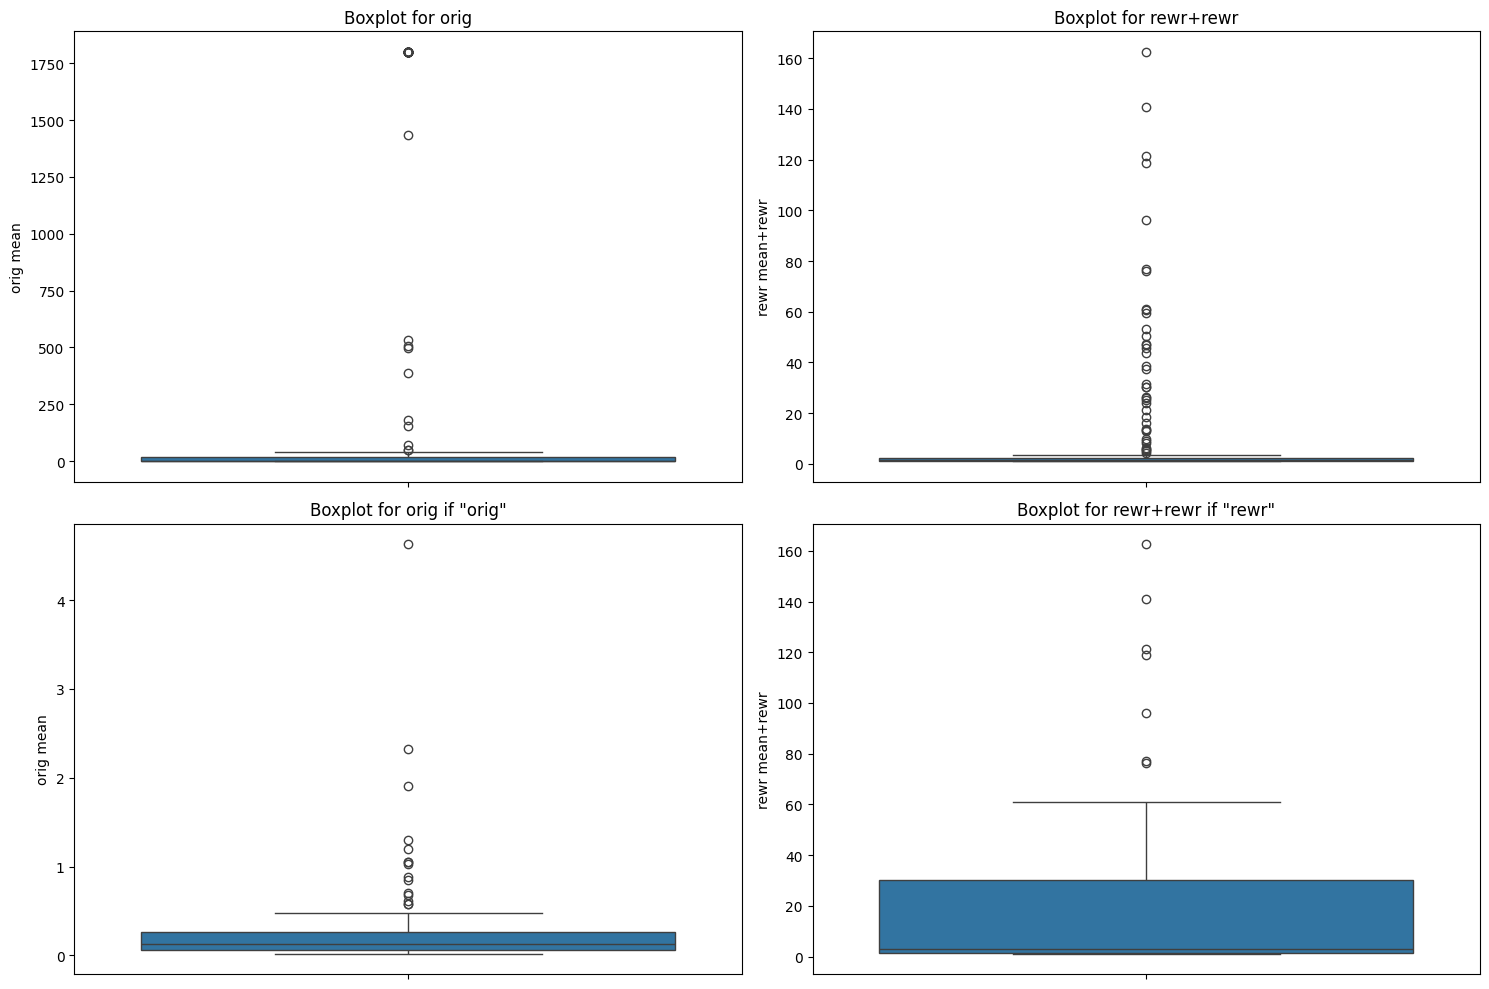

In [15]:
df_orig = df[df['orig/rewr+rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr+rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean+rewr', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr+rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean+rewr', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr+rewr if "rewr"')

plt.tight_layout()
plt.show()

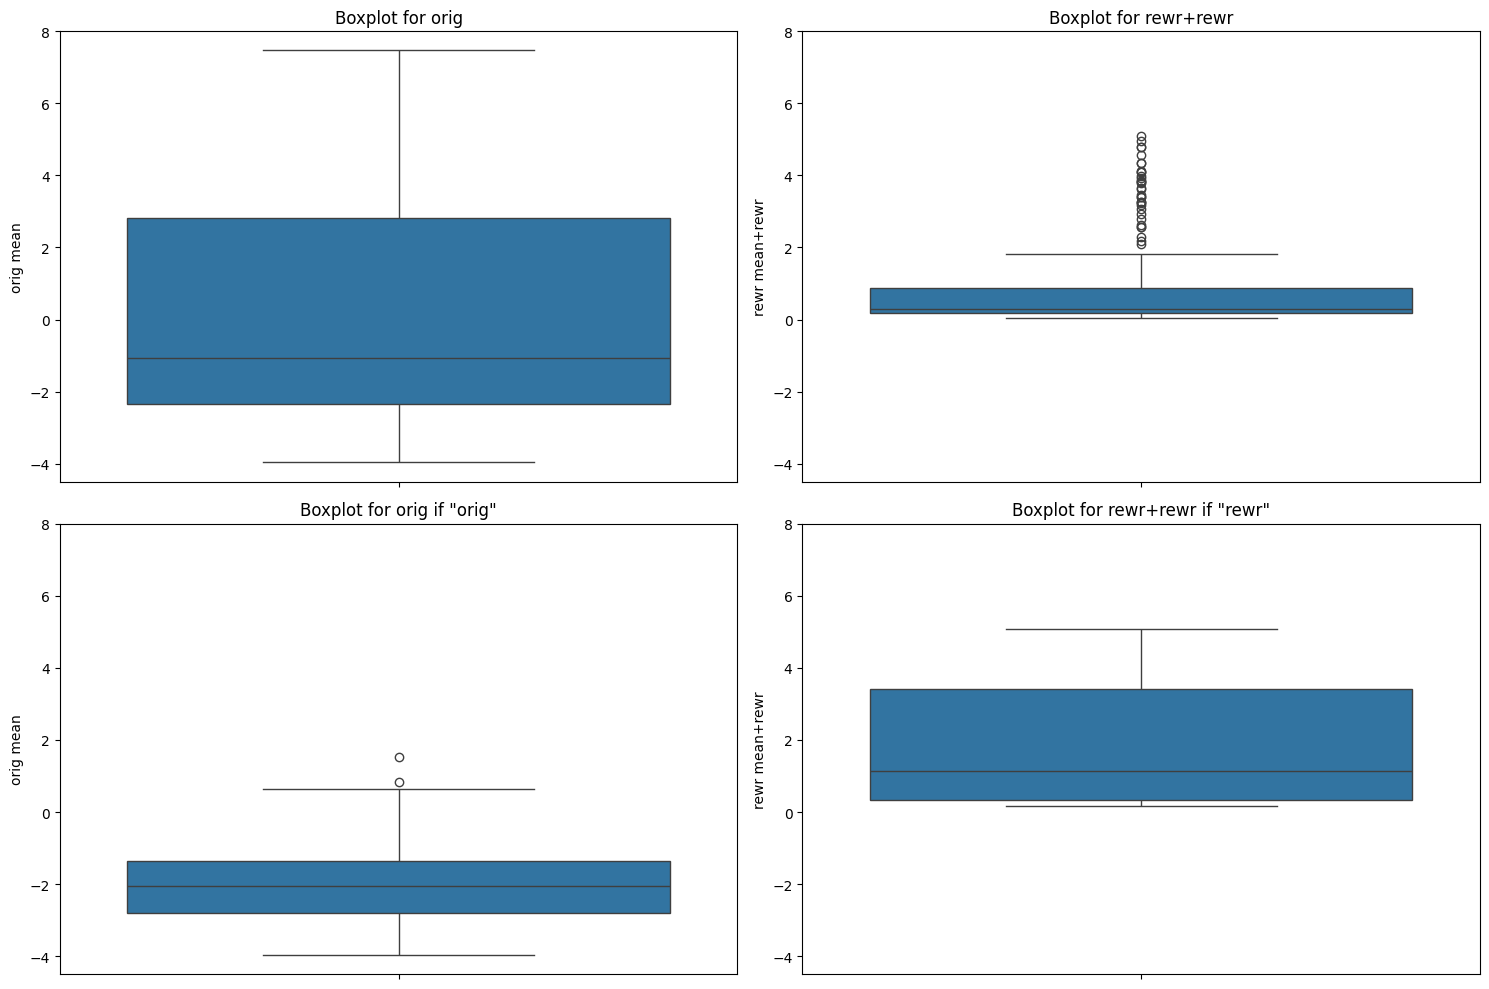

In [16]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean+rewr"] = np.log(df_log["rewr mean+rewr"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr+rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr+rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')
axes[0,0].set_ylim(-4.5, 8) 

sns.boxplot(y='rewr mean+rewr', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr+rewr')
axes[0,1].set_ylim(-4.5, 8) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')
axes[1,0].set_ylim(-4.5, 8) 

sns.boxplot(y='rewr mean+rewr', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr+rewr if "rewr"')
axes[1,1].set_ylim(-4.5, 8) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

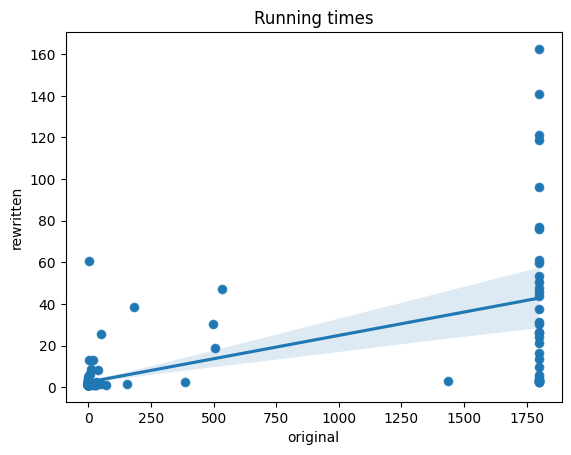

In [17]:
sns.scatterplot(x="orig mean", y="rewr mean+rewr", data=df)
sns.regplot(x="orig mean", y="rewr mean+rewr", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

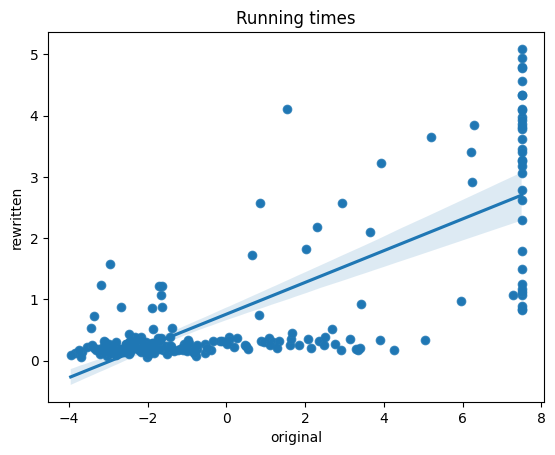

In [18]:
sns.scatterplot(x="orig mean", y="rewr mean+rewr", data=df_log)
sns.regplot(x="orig mean", y="rewr mean+rewr", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

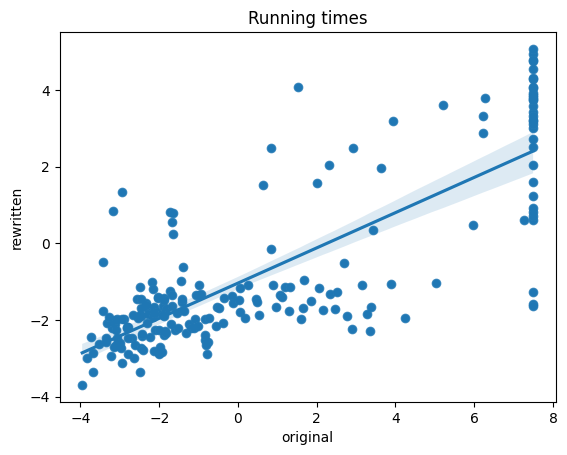

In [19]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

## Comparison of different ML methods: Classification
using test-train split, median features and decision with rewritting

* Logisitic Regression with thresholds
* Decision tree
* Random Forest
* SVM
* kNN
* Naive Bayes

### Logistic Regression with thresholds

In [20]:
model = LogisticRegression()
model.fit(X_train_small, y2_train)
X_with_intercept = sm.add_constant(X_train_small)
ols_model = sm.OLS(np.array(y2_train), X_with_intercept).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     13.48
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           9.67e-17
Time:                        06:30:47   Log-Likelihood:                -58.449
No. Observations:                 162   AIC:                             138.9
Df Residuals:                     151   BIC:                             172.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Here #filters, median(table rows) and median(container counts) are significantly different from zero.

In [21]:
X_test_with_intercept = sm.add_constant(X_test_small)
y2_pred_log_reg = ols_model.predict(X_test_with_intercept)

In [22]:
y2_pred_log_reg_00 = y2_pred_log_reg.apply(lambda x: 1 if x >= 0 else 0)
y2_pred_log_reg_035 = y2_pred_log_reg.apply(lambda x: 1 if x >= 0.35 else 0)
y2_pred_log_reg_05 = y2_pred_log_reg.apply(lambda x: 1 if x >= 0.5 else 0)
#pd.concat([y2_test, y2_pred_log_reg_00, y2_pred_log_reg_05], axis = 1)

In [23]:
accuracy = accuracy_score(y2_test, y2_pred_log_reg_00)
accuracy

0.4146341463414634

In [24]:
conf_matrix = confusion_matrix(y2_test, y2_pred_log_reg_00)
conf_matrix

array([[ 6, 17],
       [ 7, 11]])

In [25]:
accuracy = accuracy_score(y2_test, y2_pred_log_reg_05)
accuracy

0.5853658536585366

In [26]:
conf_matrix = confusion_matrix(y2_test, y2_pred_log_reg_05)
conf_matrix

array([[21,  2],
       [15,  3]])

In [27]:
accuracy = accuracy_score(y2_test, y2_pred_log_reg_035)
accuracy

0.6341463414634146

In [28]:
conf_matrix = confusion_matrix(y2_test, y2_pred_log_reg_035)
conf_matrix

array([[19,  4],
       [11,  7]])

### Decision tree

In [29]:
clf = DecisionTreeClassifier()
clf.fit(X_train_small, y2_train)
y2_pred_dec_tree = clf.predict(X_test_small)

In [30]:
accuracy = accuracy_score(y2_test, y2_pred_dec_tree)
accuracy

0.7073170731707317

In [31]:
conf_matrix = confusion_matrix(y2_test, y2_pred_dec_tree)
conf_matrix

array([[17,  6],
       [ 6, 12]])

### Random Forest

In [32]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_small, y2_train)
y2_pred_rand_forest = model.predict(X_test_small)

In [33]:
accuracy = accuracy_score(y2_test, y2_pred_rand_forest)
accuracy

0.7804878048780488

In [34]:
conf_matrix = confusion_matrix(y2_test, y2_pred_rand_forest)
conf_matrix

array([[21,  2],
       [ 7, 11]])

### SVM (Support Vector Machine)

In [35]:
clf = SVC(kernel='linear')
clf.fit(X_train_small, y2_train)
y2_pred_svm_linear = clf.predict(X_test_small)

In [36]:
clf = SVC(kernel='poly')
clf.fit(X_train_small, y2_train)
y2_pred_svm_poly = clf.predict(X_test_small)

In [37]:
clf = SVC(kernel='rbf')
clf.fit(X_train_small, y2_train)
y2_pred_svm_rbf = clf.predict(X_test_small)

In [38]:
accuracy = accuracy_score(y2_test, y2_pred_svm_linear)
accuracy

0.8048780487804879

In [39]:
conf_matrix = confusion_matrix(y2_test, y2_pred_svm_linear)
conf_matrix

array([[23,  0],
       [ 8, 10]])

In [40]:
accuracy = accuracy_score(y2_test, y2_pred_svm_poly)
accuracy

0.7804878048780488

In [41]:
conf_matrix = confusion_matrix(y2_test, y2_pred_svm_poly)
conf_matrix

array([[23,  0],
       [ 9,  9]])

In [42]:
accuracy = accuracy_score(y2_test, y2_pred_svm_rbf)
accuracy

0.7804878048780488

In [43]:
conf_matrix = confusion_matrix(y2_test, y2_pred_svm_rbf)
conf_matrix

array([[21,  2],
       [ 7, 11]])

### kNN (k-nearest neighbors)

In [44]:
clf = KNeighborsClassifier(n_neighbors=5) 
clf.fit(X_train_small, y2_train)
y2_pred_kNN_5 = clf.predict(X_test_small)

In [45]:
clf = KNeighborsClassifier(n_neighbors=10) 
clf.fit(X_train_small, y2_train)
y2_pred_kNN_10 = clf.predict(X_test_small)

In [46]:
accuracy = accuracy_score(y2_test, y2_pred_kNN_5)
accuracy

0.7317073170731707

In [47]:
conf_matrix = confusion_matrix(y2_test, y2_pred_kNN_5)
conf_matrix

array([[20,  3],
       [ 8, 10]])

In [48]:
accuracy = accuracy_score(y2_test, y2_pred_kNN_10)
accuracy

0.7804878048780488

In [49]:
conf_matrix = confusion_matrix(y2_test, y2_pred_kNN_10)
conf_matrix

array([[23,  0],
       [ 9,  9]])

### Naive Bayes

In [50]:
clf = GaussianNB()
clf.fit(X_train_small, y2_train)
y2_pred_naive_bayes = clf.predict(X_test_small)

In [51]:
accuracy = accuracy_score(y2_test, y2_pred_naive_bayes)
accuracy

0.7804878048780488

In [52]:
conf_matrix = confusion_matrix(y2_test, y2_pred_naive_bayes)
conf_matrix

array([[22,  1],
       [ 8, 10]])

## Comparison of different ML methods: Regression
using test-train split, median features and time differences with rewritting

* Linear Regression
* Ridge Regression
* Lasso Regression

### Linear Regression

In [53]:
model = LinearRegression()
model.fit(X_train_small, y2_diff_train)
X_with_intercept = sm.add_constant(X_train_small)
ols_model = sm.OLS(y2_diff_train, X_with_intercept).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     36.56
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.85e-35
Time:                        06:30:48   Log-Likelihood:                -130.24
No. Observations:                 162   AIC:                             282.5
Df Residuals:                     151   BIC:                             316.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Here #relations, #filters, #joins and median(table rows) are significantly different from zero. (And nearly median(container count).)

In [54]:
X_test_with_intercept = sm.add_constant(X_test_small)
y2_pred_lin_reg = ols_model.predict(X_test_with_intercept)

In [55]:
y2_pred_lin_reg_dec = y2_pred_lin_reg.apply(lambda x: 1 if x >= 0 else 0)
y2_diff_test_dec = y2_diff_test.apply(lambda x: 1 if x >= 0 else 0)
pd.concat([y2_pred_lin_reg, y2_diff_test, y2_pred_lin_reg_dec, y2_diff_test_dec], axis = 1)

,0,1,2,3
0,-4.251814e-01,0.420070,0,1
1,6.922469e-01,0.419707,1,1
2,7.251708e-02,0.420023,1,1
3,2.610000e-01,0.420094,1,1
4,5.587050e-01,0.420130,1,1
5,5.587050e-01,0.420407,1,1
6,4.973363e-01,0.419777,1,1
7,2.987687e-01,0.420037,1,1
8,6.241650e-01,0.419881,1,1
9,4.605331e-01,0.419276,1,1


In [56]:
mse = mean_squared_error(y2_diff_test, y2_pred_lin_reg)
mse

2485733891880008.0

In [57]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_lin_reg_dec)
accuracy

0.6097560975609756

In [58]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_lin_reg_dec)
conf_matrix

array([[ 2, 10],
       [ 6, 23]])

### Ridge Regression

alpha = 1

In [59]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_small, y2_diff_train)
y2_pred_ridge_reg = ridge.predict(X_test_small)

In [60]:
mse = mean_squared_error(y2_diff_test, y2_pred_ridge_reg)
mse

2221885234197975.0

In [61]:
y2_pred_ridge_reg_dec = pd.Series(y2_pred_ridge_reg).apply(lambda x: 1 if x >= 0 else 0)

In [62]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_ridge_reg_dec)
accuracy

0.6097560975609756

In [63]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_ridge_reg_dec)
conf_matrix

array([[ 2, 10],
       [ 6, 23]])

alpha = 0.1

In [64]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_small, y2_diff_train)
y2_pred_ridge_reg = ridge.predict(X_test_small)

In [65]:
mse = mean_squared_error(y2_diff_test, y2_pred_ridge_reg)
mse

2469561407842980.5

In [66]:
y2_pred_ridge_reg_dec = pd.Series(y2_pred_ridge_reg).apply(lambda x: 1 if x >= 0 else 0)

In [67]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_ridge_reg_dec)
accuracy

0.6097560975609756

In [68]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_ridge_reg_dec)
conf_matrix

array([[ 2, 10],
       [ 6, 23]])

alpha = 10

In [69]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_small, y2_diff_train)
y2_pred_ridge_reg = ridge.predict(X_test_small)

In [70]:
mse = mean_squared_error(y2_diff_test, y2_pred_ridge_reg)
mse

114165505160910.17

In [71]:
y2_pred_ridge_reg_dec = pd.Series(y2_pred_ridge_reg).apply(lambda x: 1 if x >= 0 else 0)

In [72]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_ridge_reg_dec)
accuracy

0.5853658536585366

In [73]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_ridge_reg_dec)
conf_matrix

array([[ 2, 10],
       [ 7, 22]])

### Lasso Regression

alpha = 1

In [74]:
lasso = Lasso(alpha=1.0) 
lasso.fit(X_train_small, y2_diff_train)
y2_pred_lasso_reg = lasso.predict(X_test_small)

In [75]:
coefficients = lasso.coef_
feature_names = X_train_small.columns
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

#relations: -0.0
#conditions: 0.0
#filters: 0.0
#joins: -0.0
total cost: -0.0
median(table rows): -0.0
median(join rows): -0.0
depth: -0.0
median(container counts): 0.0
median(branching factors): 0.0
balancedness factor: -0.0


In [76]:
mse = mean_squared_error(y2_diff_test, y2_pred_lasso_reg)
mse

1.8780170789693673

In [77]:
y2_pred_lasso_reg_dec = pd.Series(y2_pred_lasso_reg).apply(lambda x: 1 if x >= 0 else 0)

In [78]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_lasso_reg_dec)
accuracy

0.7073170731707317

In [79]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_lasso_reg_dec)
conf_matrix

array([[ 0, 12],
       [ 0, 29]])

alpha = 0.1

In [80]:
lasso = Lasso(alpha=0.1) 
lasso.fit(X_train_small, y2_diff_train)
y2_pred_lasso_reg = lasso.predict(X_test_small)

In [81]:
coefficients = lasso.coef_
feature_names = X_train_small.columns
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

#relations: -0.2911695287187925
#conditions: 0.0
#filters: 0.35552149815658446
#joins: -0.0
total cost: -0.0
median(table rows): -0.2174725244736192
median(join rows): -0.0
depth: -0.11155511476618896
median(container counts): 0.0
median(branching factors): -0.0
balancedness factor: 0.0


In [82]:
mse = mean_squared_error(y2_diff_test, y2_pred_lasso_reg)
mse

0.8928920260180396

In [83]:
y2_pred_lasso_reg_dec = pd.Series(y2_pred_lasso_reg).apply(lambda x: 1 if x >= 0 else 0)

In [84]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_lasso_reg_dec)
accuracy

0.7073170731707317

In [85]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_lasso_reg_dec)
conf_matrix

array([[ 9,  3],
       [ 9, 20]])

alpha = 0.01

In [86]:
lasso = Lasso(alpha=0.01) 
lasso.fit(X_train_small, y2_diff_train)
y2_pred_lasso_reg = lasso.predict(X_test_small)

In [87]:
coefficients = lasso.coef_
feature_names = X_train_small.columns
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

#relations: -0.7717647486184857
#conditions: 0.04016105592538272
#filters: 0.3590349484115278
#joins: 0.3914512245609261
total cost: 0.0
median(table rows): -0.26081691996121537
median(join rows): -0.024917861360271958
depth: -0.1325627265047114
median(container counts): 0.0
median(branching factors): 0.007440137251322765
balancedness factor: 0.03606312869918342


In [88]:
mse = mean_squared_error(y2_diff_test, y2_pred_lasso_reg)
mse

1.2884586065673962

In [89]:
y2_pred_lasso_reg_dec = pd.Series(y2_pred_lasso_reg).apply(lambda x: 1 if x >= 0 else 0)

In [90]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_lasso_reg_dec)
accuracy

0.7804878048780488

In [91]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_lasso_reg_dec)
conf_matrix

array([[ 9,  3],
       [ 6, 23]])

alpha = 0.0001

In [92]:
lasso = Lasso(alpha=0.0001) 
lasso.fit(X_train_small, y2_diff_train)
y2_pred_lasso_reg = lasso.predict(X_test_small)

In [93]:
coefficients = lasso.coef_
feature_names = X_train_small.columns
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

#relations: -1.3503667505441093
#conditions: 0.10024903586890029
#filters: 0.29127754606455686
#joins: 0.8111547735674018
total cost: 0.015252049311972694
median(table rows): -0.2550126826891377
median(join rows): -0.04539690957121025
depth: -0.018860777108173202
median(container counts): 0.0
median(branching factors): 0.1502281017469594
balancedness factor: 0.0590155124845305


In [94]:
mse = mean_squared_error(y2_diff_test, y2_pred_lasso_reg)
mse

2427425282499479.5

In [95]:
y2_pred_lasso_reg_dec = pd.Series(y2_pred_lasso_reg).apply(lambda x: 1 if x >= 0 else 0)

In [96]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_lasso_reg_dec)
accuracy

0.6097560975609756

In [97]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_lasso_reg_dec)
conf_matrix

array([[ 2, 10],
       [ 6, 23]])

alpha = 0.00001

In [98]:
lasso = Lasso(alpha=0.00001) 
lasso.fit(X_train_small, y2_diff_train)
y2_pred_lasso_reg = lasso.predict(X_test_small)

In [99]:
coefficients = lasso.coef_
feature_names = X_train_small.columns
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

#relations: -1.3556719276319524
#conditions: 0.10079867344465449
#filters: 0.2906558962713818
#joins: 0.8150013548120358
total cost: 0.015415936278793658
median(table rows): -0.25496419438981505
median(join rows): -0.045581584491641625
depth: -0.017824924212891342
median(container counts): 0.0
median(branching factors): 0.15153574124472913
balancedness factor: 0.05922634724808835


In [100]:
mse = mean_squared_error(y2_diff_test, y2_pred_lasso_reg)
mse

2479872100076132.0

In [101]:
y2_pred_lasso_reg_dec = pd.Series(y2_pred_lasso_reg).apply(lambda x: 1 if x >= 0 else 0)

In [102]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_lasso_reg_dec)
accuracy

0.6097560975609756

In [103]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_lasso_reg_dec)
conf_matrix

array([[ 2, 10],
       [ 6, 23]])

alpha = 10

In [104]:
lasso = Lasso(alpha=10.0) 
lasso.fit(X_train_small, y2_diff_train)
y2_pred_lasso_reg = lasso.predict(X_test_small)

In [105]:
coefficients = lasso.coef_
feature_names = X_train_small.columns
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

#relations: -0.0
#conditions: 0.0
#filters: 0.0
#joins: -0.0
total cost: -0.0
median(table rows): -0.0
median(join rows): -0.0
depth: -0.0
median(container counts): 0.0
median(branching factors): 0.0
balancedness factor: -0.0


In [106]:
mse = mean_squared_error(y2_diff_test, y2_pred_lasso_reg)
mse

1.8780170789693673

In [107]:
y2_pred_lasso_reg_dec = pd.Series(y2_pred_lasso_reg).apply(lambda x: 1 if x >= 0 else 0)

In [108]:
accuracy = accuracy_score(y2_diff_test_dec, y2_pred_lasso_reg_dec)
accuracy

0.7073170731707317

In [109]:
conf_matrix = confusion_matrix(y2_diff_test_dec, y2_pred_lasso_reg_dec)
conf_matrix

array([[ 0, 12],
       [ 0, 29]])

Since Lasso can also be used for feature selection, we look at the coefficients of the different Lasso models.
It seems like median(container counts) is the least important feature, followed by median(join rows) and median(branching factors). Whereas #relations, 
#filters, median(table rows) and depth seem to be the most important features.

### All possible settings: example Random Forest

#### train-test, y1, all features

In [110]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y1_train)
y1_all_tt_pred_rand_forest = clf.predict(X_test)

In [111]:
accuracy = accuracy_score(y1_test, y1_all_tt_pred_rand_forest)
conf_matrix = confusion_matrix(y1_test, y1_all_tt_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.8292682926829268
[[ 8  1]
 [ 6 26]]


#### train-test, y1, some features

In [112]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_small, y1_train)
y1_some_tt_pred_rand_forest = clf.predict(X_test_small)

In [113]:
accuracy = accuracy_score(y1_test, y1_some_tt_pred_rand_forest)
conf_matrix = confusion_matrix(y1_test, y1_some_tt_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.8292682926829268
[[ 8  1]
 [ 6 26]]


#### train-test, y2, all features

In [114]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y2_train)
y2_all_tt_pred_rand_forest = clf.predict(X_test)

In [115]:
accuracy = accuracy_score(y2_test, y2_all_tt_pred_rand_forest)
conf_matrix = confusion_matrix(y2_test, y2_all_tt_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.8048780487804879
[[21  2]
 [ 6 12]]


#### train-test, y2, some features

In [116]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_small, y2_train)
y2_some_tt_pred_rand_forest = clf.predict(X_test_small)

In [117]:
accuracy = accuracy_score(y2_test, y2_some_tt_pred_rand_forest)
conf_matrix = confusion_matrix(y2_test, y2_some_tt_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.7804878048780488
[[21  2]
 [ 7 11]]


#### CV, y1, all features

In [118]:
clf = RandomForestClassifier(n_estimators=100)
y1_all_cv_pred_rand_forest = cross_val_predict(clf, X_scaled, y1, cv=5)

In [119]:
accuracy = accuracy_score(y1, y1_all_cv_pred_rand_forest)
conf_matrix = confusion_matrix(y1, y1_all_cv_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.7192118226600985
[[51 22]
 [35 95]]


#### CV, y1, some features

In [120]:
clf = RandomForestClassifier(n_estimators=100)
y1_some_cv_pred_rand_forest = cross_val_predict(clf, X_small, y1, cv=5)

In [121]:
accuracy = accuracy_score(y1, y1_some_cv_pred_rand_forest)
conf_matrix = confusion_matrix(y1, y1_some_cv_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.6748768472906403
[[40 33]
 [33 97]]


#### CV, y2, all features

In [122]:
clf = RandomForestClassifier(n_estimators=100)
y2_all_cv_pred_rand_forest = cross_val_predict(clf, X_scaled, y2, cv=5)

In [123]:
accuracy = accuracy_score(y2, y2_all_cv_pred_rand_forest)
conf_matrix = confusion_matrix(y2, y2_all_cv_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.8275862068965517
[[118  10]
 [ 25  50]]


#### CV, y2, some features

In [124]:
clf = RandomForestClassifier(n_estimators=100)
y2_some_cv_pred_rand_forest = cross_val_predict(clf, X_small, y2, cv=5)

In [125]:
accuracy = accuracy_score(y2, y2_all_cv_pred_rand_forest)
conf_matrix = confusion_matrix(y2, y2_all_cv_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.8275862068965517
[[118  10]
 [ 25  50]]


### All possible settings: example Logistic Regression

#### train-test, y1, all features

In [126]:
model = LogisticRegression()
model.fit(X_train, y1_train)
X_with_intercept = sm.add_constant(X_train)
ols_model = sm.OLS(np.array(y1_train), X_with_intercept).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     1.923
Date:                Mon, 08 Apr 2024   Prob (F-statistic):             0.0104
Time:                        06:30:51   Log-Likelihood:                -90.413
No. Observations:                 162   AIC:                             230.8
Df Residuals:                     137   BIC:                             308.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The only two significantly different from zero features are #filters and max(container counts).

In [127]:
X_test_with_intercept = sm.add_constant(X_test)
y1_all_tt_pred_log_dec = ols_model.predict(X_test_with_intercept)

In [128]:
y1_all_tt_pred_log_dec = y1_all_tt_pred_log_dec.apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y1_test, y1_all_tt_pred_log_dec)
conf_matrix = confusion_matrix(y1_test, y1_all_tt_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.6829268292682927
[[ 3  6]
 [ 7 25]]


#### train-test, y1, some features

OLS (ordinary least square) regression with train-test split and only the median of the features occuring multiple times, because the features now are highly correlated.

In [129]:
model = LogisticRegression()
model.fit(X_train_small, y1_train)
X_with_intercept = sm.add_constant(X_train_small)
ols_model = sm.OLS(np.array(y1_train), X_with_intercept).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     3.763
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           0.000154
Time:                        06:30:51   Log-Likelihood:                -95.907
No. Observations:                 162   AIC:                             213.8
Df Residuals:                     151   BIC:                             247.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Here #filter, #joins and median(container counts) for $\alpha = 0.05$ are significant.   
Additionally, #relations and balancedness factor for $\alpha = 0.1$ are significant.

---

Predictions for the test set using the OLS model:

In [130]:
X_test_with_intercept = sm.add_constant(X_test_small)
y1_some_tt_pred_log_dec = ols_model.predict(X_test_with_intercept)

In [131]:
y1_some_tt_pred_log_dec = y1_some_tt_pred_log_dec.apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y1_test, y1_some_tt_pred_log_dec)
conf_matrix = confusion_matrix(y1_test, y1_some_tt_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.6341463414634146
[[ 2  7]
 [ 8 24]]


#### train-test, y2, all features

In [132]:
model = LogisticRegression()
model.fit(X_train, y2_train)
X_with_intercept = sm.add_constant(X_train)
ols_model = sm.OLS(np.array(y2_train), X_with_intercept).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     6.515
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           2.48e-13
Time:                        06:30:51   Log-Likelihood:                -48.463
No. Observations:                 162   AIC:                             146.9
Df Residuals:                     137   BIC:                             224.1
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Only #filters is significant here

In [133]:
X_test_with_intercept = sm.add_constant(X_test)
y2_all_tt_pred_log_dec = ols_model.predict(X_test_with_intercept)

In [134]:
y2_all_tt_pred_log_dec = y2_all_tt_pred_log_dec.apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y2_test, y2_all_tt_pred_log_dec)
conf_matrix = confusion_matrix(y2_test, y2_all_tt_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.7317073170731707
[[21  2]
 [ 9  9]]


#### train-test, y2, some features

In [135]:
model = LogisticRegression()
model.fit(X_train_small, y1_train)
X_with_intercept = sm.add_constant(X_train_small)
ols_model = sm.OLS(np.array(y1_train), X_with_intercept).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     3.763
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           0.000154
Time:                        06:30:51   Log-Likelihood:                -95.907
No. Observations:                 162   AIC:                             213.8
Df Residuals:                     151   BIC:                             247.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

For $\alpha = 0.05$: #filters, #joins and median(container counts) significant   
For $\alpha = 0.1$: additionally #relations and balancedness factor

In [136]:
X_test_with_intercept = sm.add_constant(X_test_small)
y2_some_tt_pred_log_dec = ols_model.predict(X_test_with_intercept)

In [137]:
y2_some_tt_pred_log_dec = y2_some_tt_pred_log_dec.apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y2_test, y2_some_tt_pred_log_dec)
conf_matrix = confusion_matrix(y2_test, y2_some_tt_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.34146341463414637
[[ 3 20]
 [ 7 11]]


#### CV, y1, all features

In [138]:
model = LogisticRegression()
y1_all_cv_pred_log_dec = cross_val_predict(model, X_scaled, y1, cv=2)

In [139]:
y1_all_cv_pred_log_dec = pd.Series(y1_all_cv_pred_log_dec).apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y1, y1_all_cv_pred_log_dec)
conf_matrix = confusion_matrix(y1, y1_all_cv_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.4482758620689655
[[46 27]
 [85 45]]


#### CV, y1, some features

In [140]:
model = LogisticRegression()
y1_some_cv_pred_log_dec = cross_val_predict(model, X_small, y1, cv=5)

In [141]:
y1_some_cv_pred_log_dec = pd.Series(y1_some_cv_pred_log_dec).apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y1, y1_some_cv_pred_log_dec)
conf_matrix = confusion_matrix(y1, y1_some_cv_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.5763546798029556
[[21 52]
 [34 96]]


#### CV, y2, all features

In [142]:
model = LogisticRegression()
y2_all_cv_pred_log_dec = cross_val_predict(model, X_scaled, y2, cv=5)

In [143]:
y2_all_cv_pred_log_dec = pd.Series(y2_all_cv_pred_log_dec).apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y2, y2_all_cv_pred_log_dec)
conf_matrix = confusion_matrix(y2, y2_all_cv_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.7931034482758621
[[116  12]
 [ 30  45]]


#### CV, y2, some features

In [144]:
model = LogisticRegression()
y2_some_cv_pred_log_dec = cross_val_predict(model, X_small, y2, cv=5)

In [145]:
y2_some_cv_pred_log_dec = pd.Series(y2_some_cv_pred_log_dec).apply(lambda x: 1 if x >= 0.35 else 0)

accuracy = accuracy_score(y2, y2_some_cv_pred_log_dec)
conf_matrix = confusion_matrix(y2, y2_some_cv_pred_log_dec)
print(accuracy)
print(conf_matrix)

0.8029556650246306
[[114  14]
 [ 26  49]]


## Inspection of the misclassifications

In [146]:
clf = SVC(kernel='linear')
clf.fit(X_train_small, y2_train)
y2_pred_svm_linear = clf.predict(X_test_small)

In [147]:
accuracy = accuracy_score(y2_test, y2_pred_svm_linear)
conf_matrix = confusion_matrix(y2_test, y2_pred_svm_linear)
print(accuracy)
print(conf_matrix)

0.8048780487804879
[[23  0]
 [ 8 10]]


In [148]:
pd.concat([pd.Series(y2_test), pd.Series(y2_pred_svm_linear, index = pd.Series(y2_test).index)], axis = 1)

,orig/rewr+rewr(mean),0
40,0,0
41,0,0
42,0,0
43,0,0
44,0,0
45,0,0
46,0,0
47,0,0
48,0,0
49,0,0


All of the misclassification are STATS queries at the end of the STATS benchmark...we splitted the benchmark by hand, such that the last ones are all in the test set, so it seems that there is a component we did not take into consideration yet, which has an high influence.

In [149]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_small, y2_train)
y2_pred_rand_forest = model.predict(X_test_small)

In [150]:
accuracy = accuracy_score(y2_test, y2_pred_rand_forest)
conf_matrix = confusion_matrix(y2_test, y2_pred_rand_forest)
print(accuracy)
print(conf_matrix)

0.8048780487804879
[[21  2]
 [ 6 12]]


In [151]:
pd.concat([pd.Series(y2_test), pd.Series(y2_pred_rand_forest, index = pd.Series(y2_test).index)], axis = 1)

,orig/rewr+rewr(mean),0
40,0,0
41,0,0
42,0,0
43,0,0
44,0,0
45,0,0
46,0,0
47,0,0
48,0,0
49,0,0


Again all the last STATS queries are misclassified. Additionally 2 of the SNAP queries are misclassified.

In [152]:
X_with_intercept = sm.add_constant(X_train_small)
ols_model = sm.OLS(np.array(y2_train), X_with_intercept).fit()

In [153]:
X_test_with_intercept = sm.add_constant(X_test_small)
y2_pred_log_reg = ols_model.predict(X_test_with_intercept)

In [154]:
y2_pred_log_reg_035 = y2_pred_log_reg.apply(lambda x: 1 if x >= 0.35 else 0)

In [155]:
accuracy = accuracy_score(y2_test, y2_pred_log_reg_035)
conf_matrix = confusion_matrix(y2_test, y2_pred_log_reg_035)
print(accuracy)
print(conf_matrix)

0.6341463414634146
[[19  4]
 [11  7]]


In [156]:
pd.concat([pd.Series(y2_test), pd.Series(y2_pred_log_reg_035.values, index = pd.Series(y2_test).index)], axis = 1)

,orig/rewr+rewr(mean),0
40,0,1
41,0,0
42,0,0
43,0,0
44,0,0
45,0,0
46,0,0
47,0,0
48,0,0
49,0,0


This one behaves completely differently. But again only STATS queries are misclassified (however in this case all over the benchmark dataset).

Changing of the train test split only for getting insights (should not be done in general!)

In [157]:
X_train_raw2 = X.iloc[list(range(0, 40)) + list(range(50, 90)) + list(range(100, 135)) + list(range(142, 144)) + list(range(147, 178)) + list(range(187, 199)) + 
list(range(201, 202))]
X_test_raw2 = X.iloc[list(range(40, 50)) + list(range(90, 100)) + list(range(135, 142)) + list(range(144,147)) + list(range(178, 187)) + list(range(199, 201)) +
list(range(202, 203))]
y2_train2 = y2.iloc[list(range(0, 40)) + list(range(50, 90)) + list(range(100, 135)) + list(range(142, 144)) + list(range(147, 178)) + list(range(187, 199)) + 
list(range(201, 202))]
y2_test2 = y2.iloc[list(range(40, 50)) + list(range(90, 100)) + list(range(135, 142)) + list(range(144,147)) + list(range(178, 187)) + list(range(199, 201)) +
list(range(202, 203))]

In [158]:
scaler = StandardScaler()
scaler.fit(X_train_raw2)
X_train2 = pd.DataFrame(scaler.transform(X_train_raw2), columns=X_train_raw2.columns)
X_test2 = pd.DataFrame(scaler.transform(X_test_raw2), columns=X_test_raw2.columns)

In [159]:
X_train_small2 = X_train2.iloc[:,[0,1,2,3,4,9,15,17,22,27,28]]
X_test_small2 = X_test2.iloc[:,[0,1,2,3,4,9,15,17,22,27,28]]

In [160]:
clf = SVC(kernel='linear')
clf.fit(X_train_small2, y2_train2)
y2_pred_svm_linear2 = clf.predict(X_test_small2)

In [161]:
accuracy = accuracy_score(y2_test2, y2_pred_svm_linear2)
conf_matrix = confusion_matrix(y2_test2, y2_pred_svm_linear2)
print(accuracy)
print(conf_matrix)

0.8095238095238095
[[23  0]
 [ 8 11]]


In [162]:
pd.concat([pd.Series(y2_test2), pd.Series(y2_pred_svm_linear2, index = pd.Series(y2_test2).index)], axis = 1)

,orig/rewr+rewr(mean),0
40,0,0
41,0,0
42,0,0
43,0,0
44,0,0
45,0,0
46,0,0
47,0,0
48,0,0
49,0,0


Very interestingly again 8 STATS queries are misclassified, so i could not take the other training samples to its advantage.

In [163]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_small2, y2_train2)
y2_pred_rand_forest2 = model.predict(X_test_small2)

In [164]:
accuracy = accuracy_score(y2_test2, y2_pred_rand_forest2)
conf_matrix = confusion_matrix(y2_test2, y2_pred_rand_forest2)
print(accuracy)
print(conf_matrix)

0.8809523809523809
[[23  0]
 [ 5 14]]


In [165]:
pd.concat([pd.Series(y2_test2), pd.Series(y2_pred_rand_forest2, index = pd.Series(y2_test2).index)], axis = 1)

,orig/rewr+rewr(mean),0
40,0,0
41,0,0
42,0,0
43,0,0
44,0,0
45,0,0
46,0,0
47,0,0
48,0,0
49,0,0


In this case it helped, since we exactly excluded those, which the model had problems with before. And it also classified the SNAP queries here correctly.

In [166]:
X_with_intercept2 = sm.add_constant(X_train_small2)
ols_model = sm.OLS(np.array(y2_train2), X_with_intercept2).fit()

In [167]:
X_test_with_intercept2 = sm.add_constant(X_test_small2)
y2_pred_log_reg2 = ols_model.predict(X_test_with_intercept2)

In [168]:
y2_pred_log_reg_0352 = y2_pred_log_reg2.apply(lambda x: 1 if x >= 0.35 else 0)

In [169]:
accuracy = accuracy_score(y2_test2, y2_pred_log_reg_0352)
conf_matrix = confusion_matrix(y2_test2, y2_pred_log_reg_0352)
print(accuracy)
print(conf_matrix)

0.6666666666666666
[[20  3]
 [11  8]]


In [170]:
pd.concat([pd.Series(y2_test2), pd.Series(y2_pred_log_reg_0352.values, index = pd.Series(y2_test2).index)], axis = 1)

,orig/rewr+rewr(mean),0
40,0,1
41,0,0
42,0,0
43,0,0
44,0,0
45,0,0
46,0,0
47,0,0
48,0,0
49,0,0
